# TASK #1: PROJECT OVERVIEW

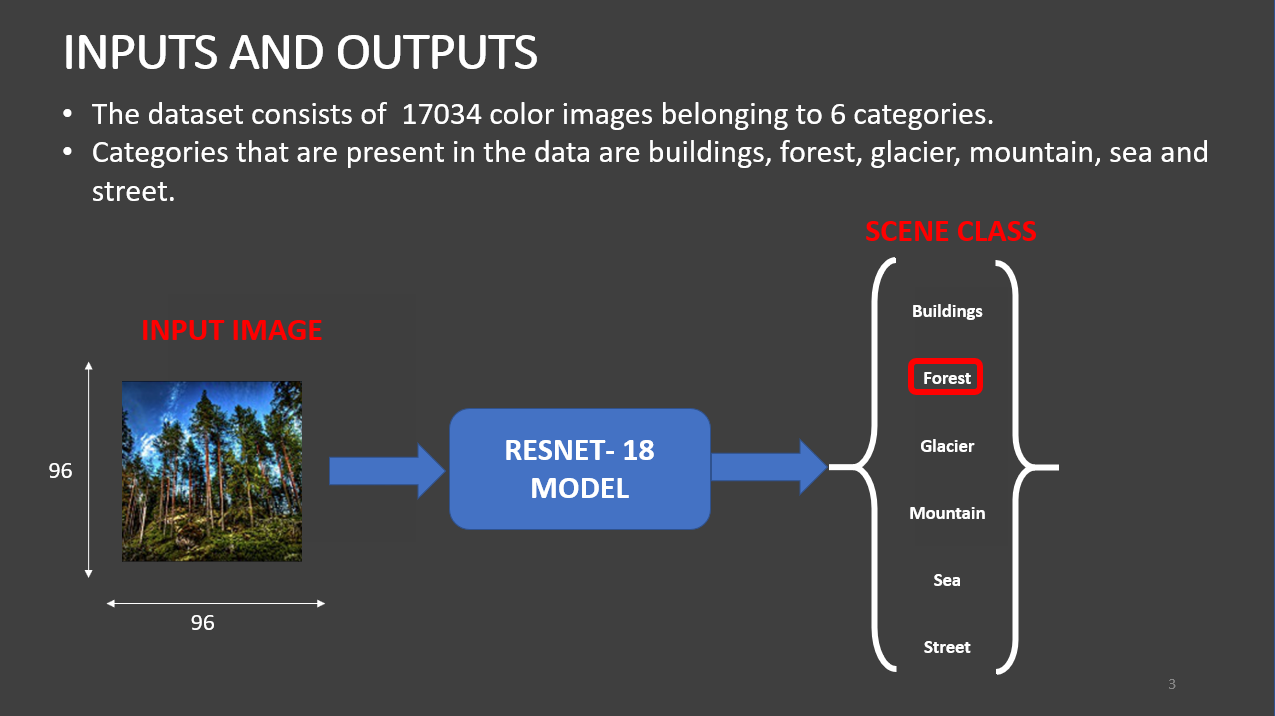

# TASK #2: IMPORT LIBRARIES/DATASETS

In [2]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import os
import PIL
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


ModuleNotFoundError: No module named 'jupyterthemes'

In [ ]:
# Check the number of images in training, validation and test dataset

train = []
test = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./seg_train'):
  train_class = os.listdir(os.path.join('seg_train', i))
  train.extend(train_class)
  test_class = os.listdir(os.path.join('seg_test', i))
  test.extend(test_class)


# TASK #3: DATA EXPLORATION AND DATA VISUALIZATION:

In [ ]:
# Visualize the images in the dataset

fig, axs = plt.subplots(6,5, figsize=(32,32))
count = 0
for i in os.listdir('./seg_train'):
  # get the list of images in the particular class
  train_class = os.listdir(os.path.join('seg_train',i))
  # plot 5 images per class
  for j in range(5):
        img = os.path.join('seg_train',i,train_class[j])
        img = PIL.Image.open(img)
        axs[count][j].imshow(img)
        axs[count][j].set_title(i, fontsize=30)

  count+=1
fig.tight_layout()


In [ ]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('./seg_train'):
  train_class = os.listdir(os.path.join('seg_train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

In [ ]:
# plot pie chart
fig1, ax1=plt.subplots()
ax1.pie(No_images_per_class,labels=Class_name,autopct='%1.1f%%')
plt.show()

MINI CHALLENGE #1:

- Create a similar visualization but for the testing dataset instead of the training dataset. 


# TASK #4: PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [ ]:
# create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip


# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_directory(
        'seg_train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        subset ='training')

validation_generator = train_datagen.flow_from_directory(
        'seg_train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        subset ='validation')


MINI CHALLENGE #2:

- Experiment with other image augmentation strategies to the training data. Pick at least 1 augmentation strategy. 

HINT: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator




# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS (CNN) AND RESIDUAL BLOCKS

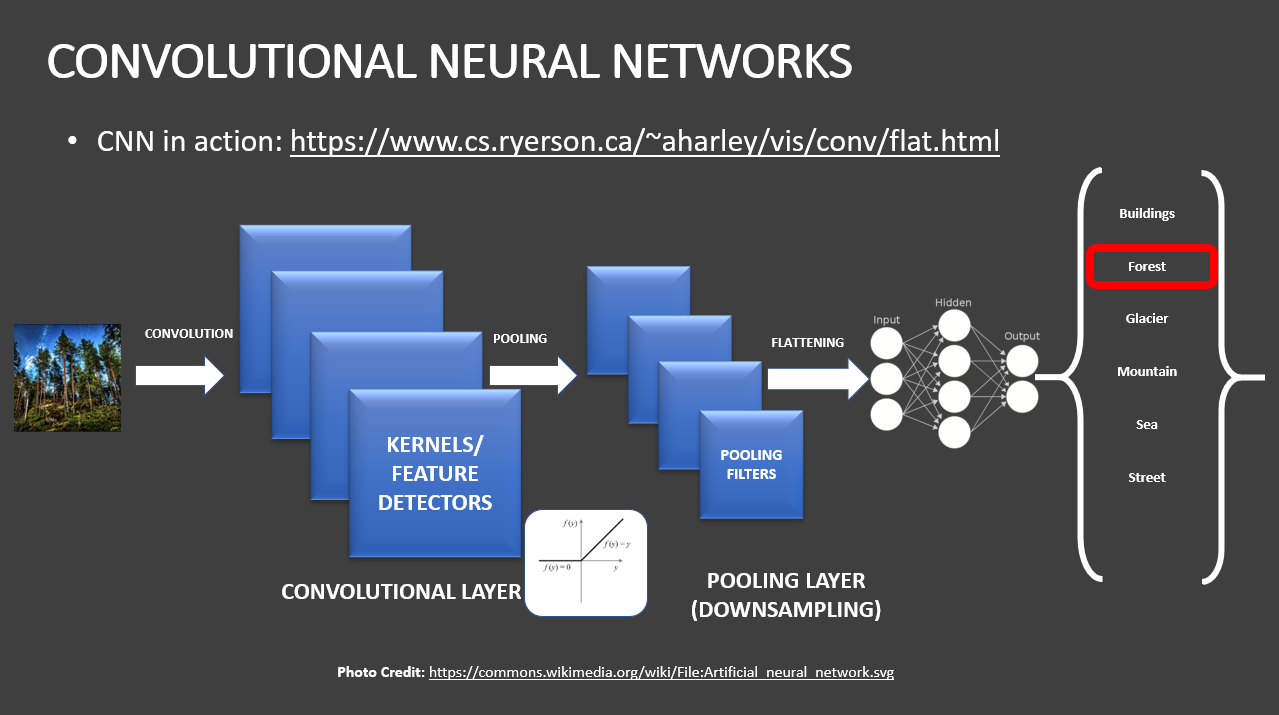

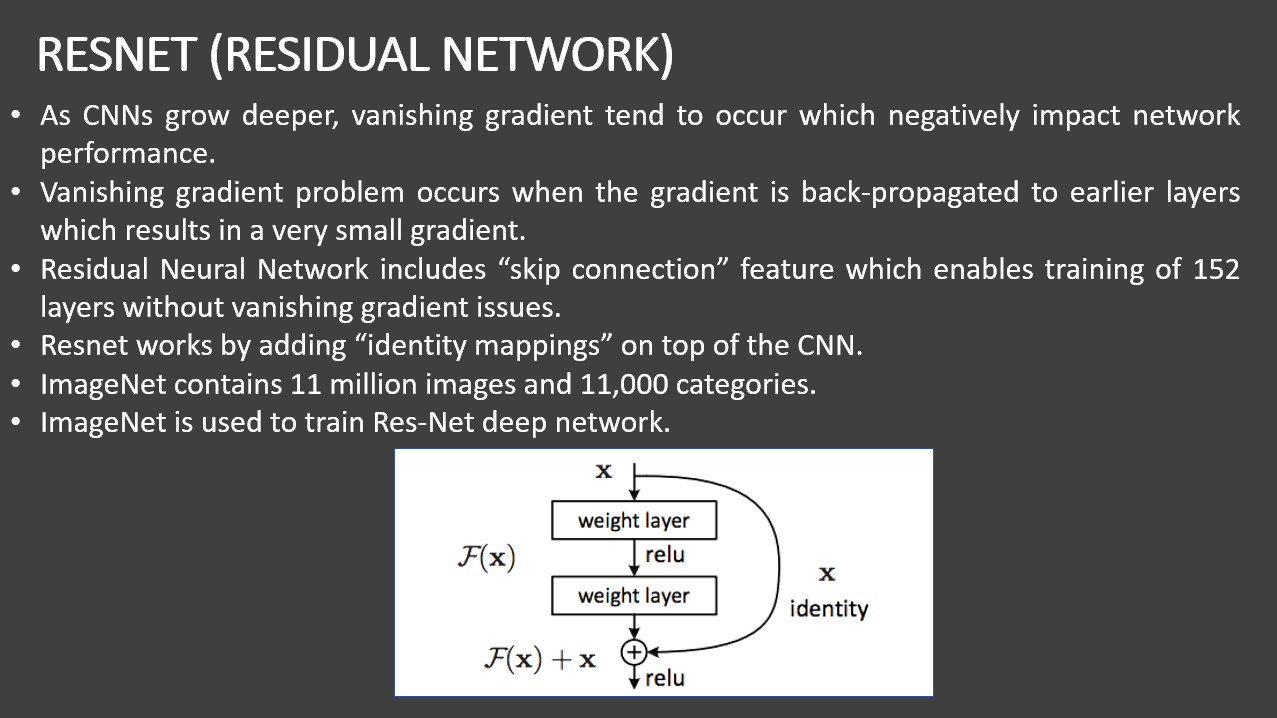

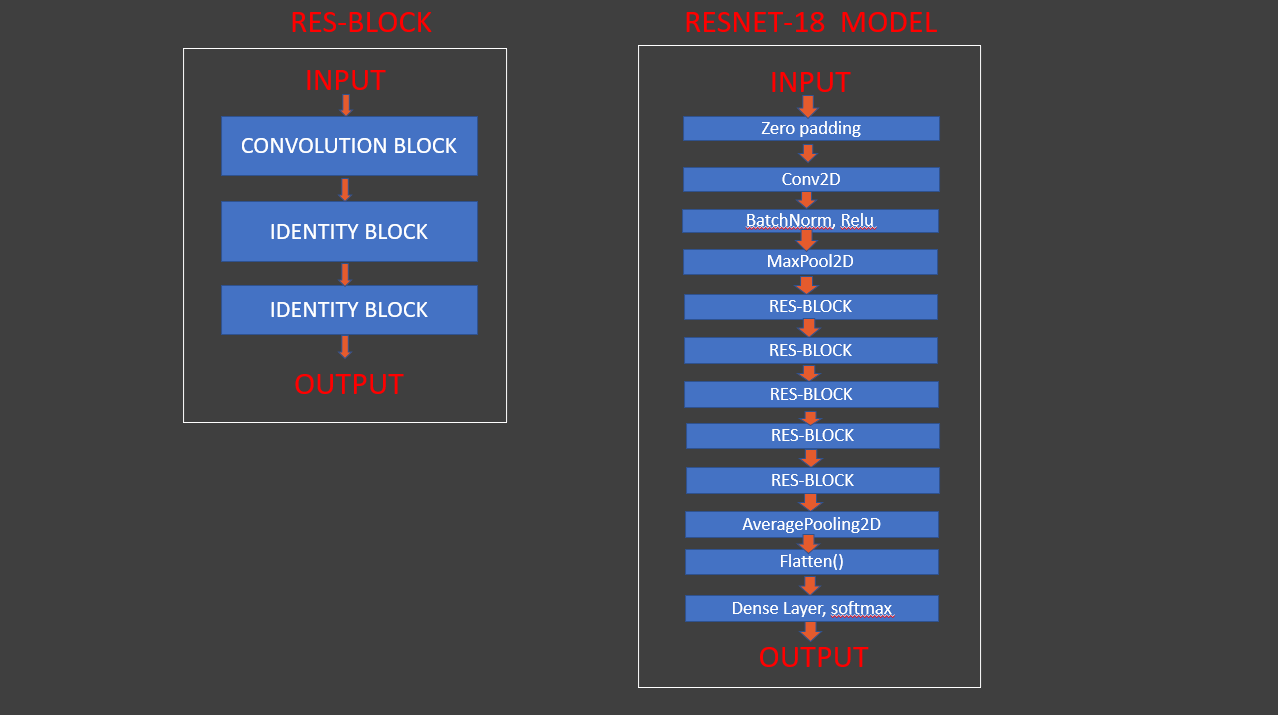

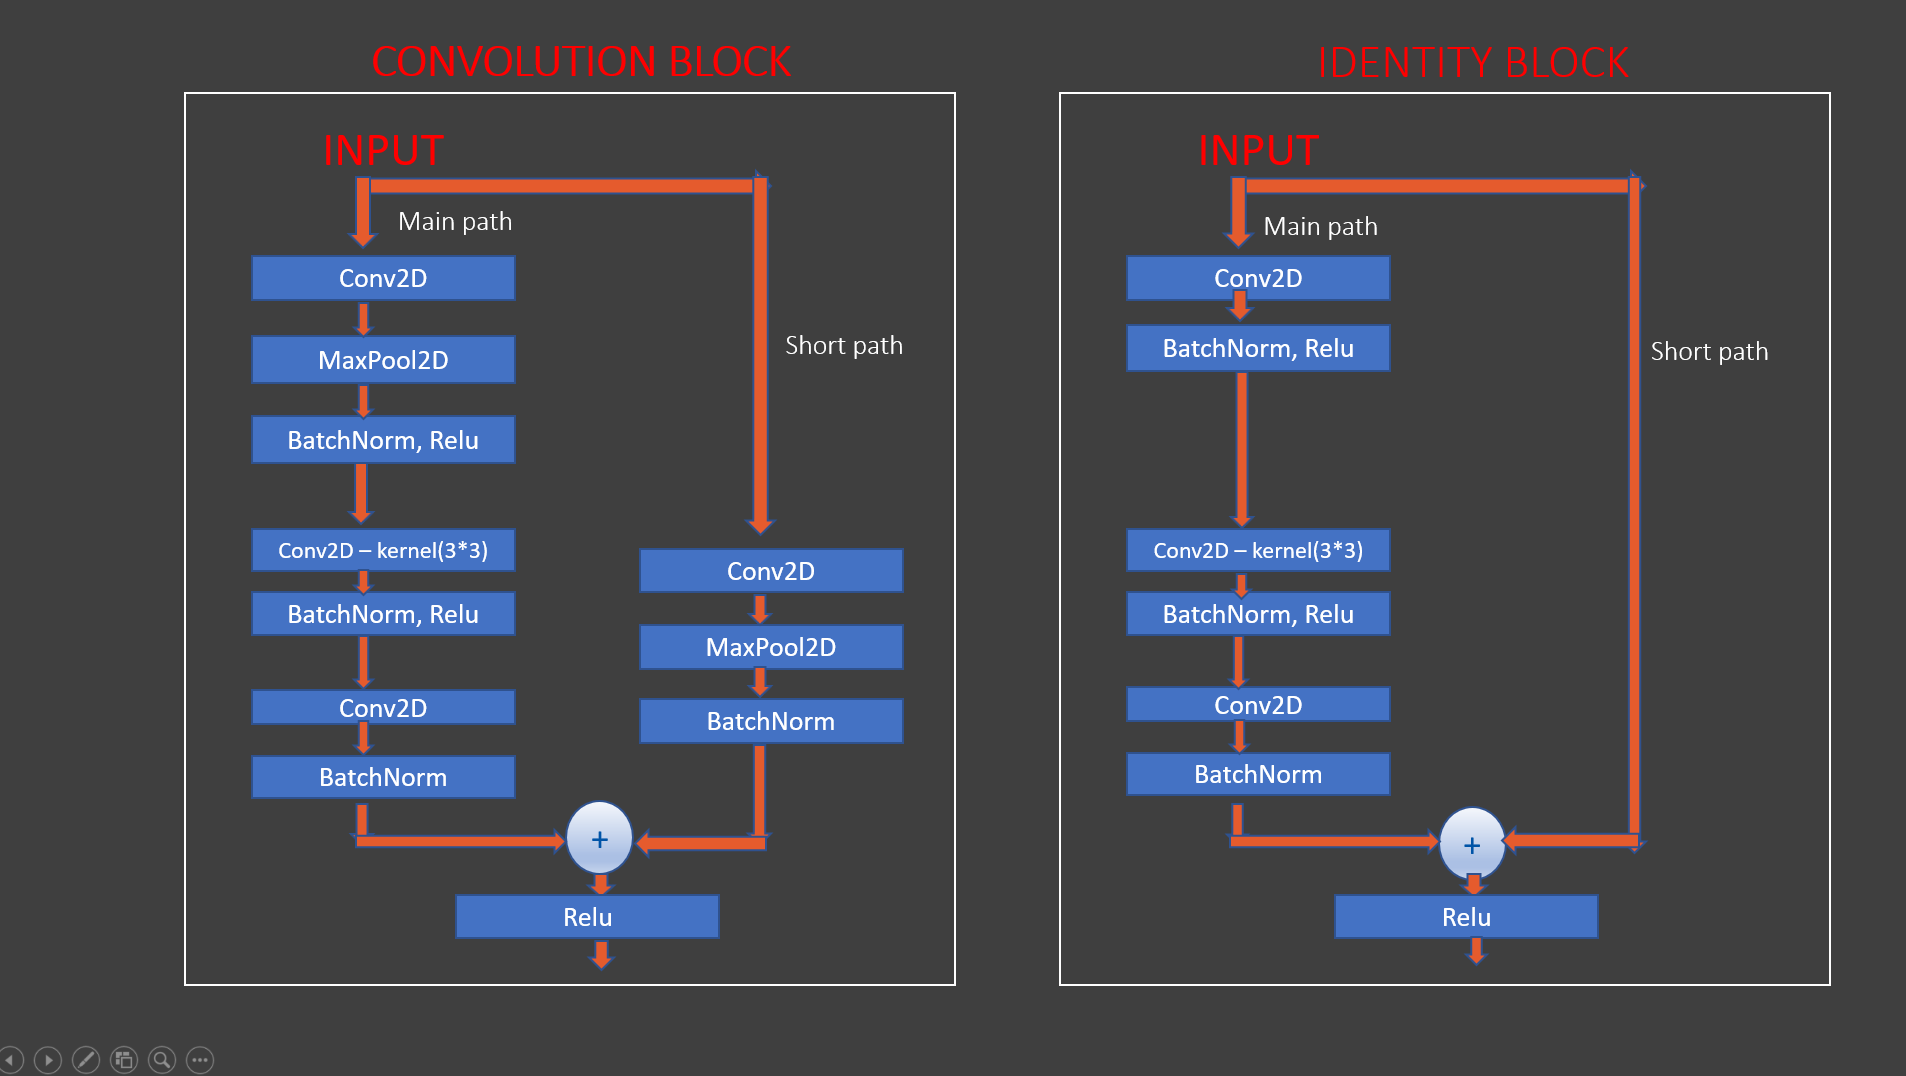

MINI CHALLENGE #3:
- What is the performance of ResNets on the ImageNet datasets? (External Research is required)

# TASK #6: BUILD RESNET MODEL

In [ ]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:

input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage
X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage
X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(6, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

MINI CHALLENGE #4:

- Try to remove max pooling layers from the residual blocks and add dropout layers to the model. 


# TASK #7: COMPILE AND TRAIN DEEP LEARNING MODEL

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 1, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

MINI CHALLENGE #5: 
 - Try a different optimizer and retrain the model (Take Home) 
 - Change the value of patience in early stopping

# TASK #8: ASSESS THE PERFORMANCE OF THE TRAINED MODEL

In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)



In [ ]:
# assign label names to the corresponding indexes
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3:'mountain', 4: 'sea', 5:'street'}

In [ ]:
# load images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir('./seg_test'):
  for item in os.listdir(os.path.join('./seg_test', i)):
    # code to open the image
    img= PIL.Image.open(os.path.join('./seg_test', i, item))
    # resizing the image to (256,256)
    img = img.resize((256, 256))
    # appending image to the image list
    image.append(img)
    # converting image to array
    img = np.asarray(img, dtype = np.float32)
    # normalizing the image
    img = img / 255
    # reshaping the image into a 4D array
    img = img.reshape(-1, 256, 256, 3)
    # making prediction of the model
    predict = model.predict(img)
    # getting the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    # appending the predicted class to the list
    prediction.append(labels[predict])
    # appending original class to the list
    original.append(i)


In [ ]:
# Get the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

In [ ]:
# visualize the results
import random
fig = plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0, len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()